In [1]:
#Import libraries as needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Start Spark Session
from pyspark . sql import SparkSession
spark = SparkSession . builder . appName ('yuck').getOrCreate ()


In [55]:
#Import single csv file to dataframe
df = pd.read_csv ('madrid_2017.csv ', delimiter =',')

In [42]:
#STEP 1: IMPUTE DATA AND MAKE SURE U HAVE CHOSEN
#the most suitable imputaion method

df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index of the DataFrame
df = df.set_index('date')

# Interpolate missing values using time-based interpolation
df= df.interpolate(method='time',limit_direction='both')

# Reset the index to use an integer index instead of 'date'
df = df.reset_index(drop=False)

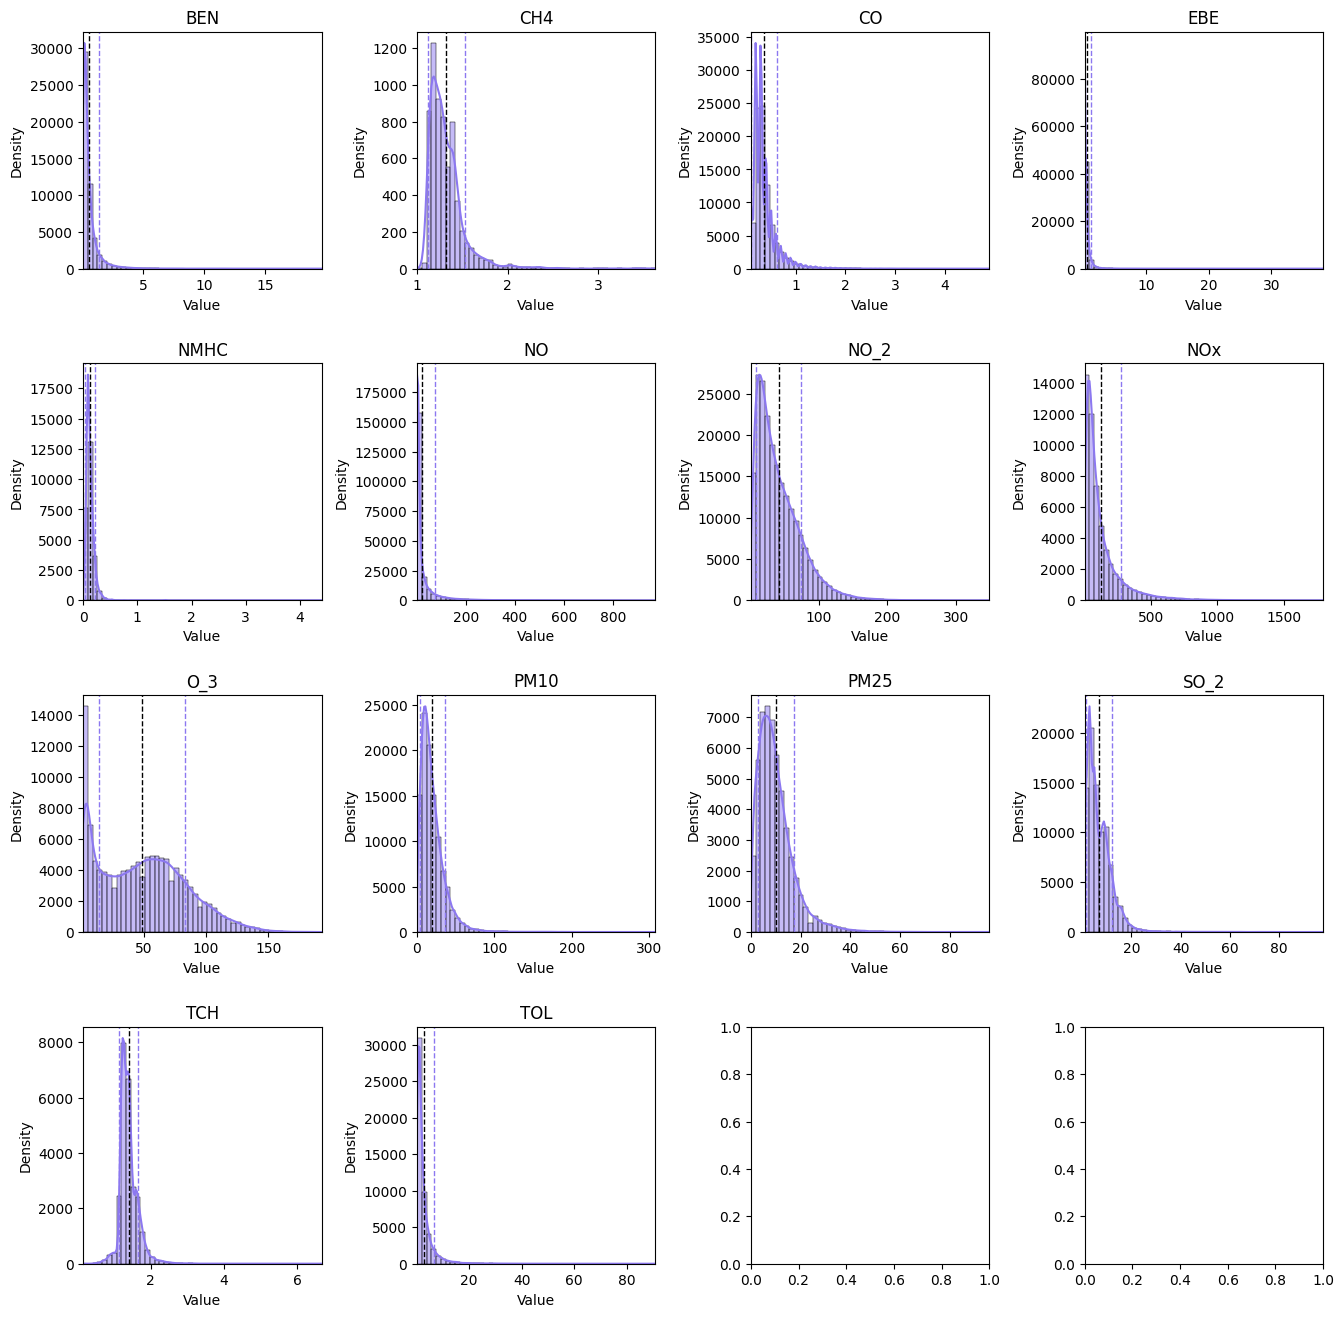

In [56]:
#STEP 2: HISTOGRAMS

# Get the columns to plot
pollutants = df.columns[1:-1]

# Create a figure with 4x4 subplots
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

# Plot a histogram for each column
for i, pollutant in enumerate(pollutants):
    # Get the data for the column
    data = df[pollutant].dropna()
    
    # Determine the subplot location based on the column index
    row = i // 4
    col = i % 4
    
    # Plot the histogram with kde
    sns.histplot(data, kde=True, bins=50, color='#8C78F0', ax=axs[row, col])
    
    # Add a vertical line for the mean
    mean = data.mean()
    axs[row, col].axvline(mean, color='k', linestyle='dashed', linewidth=1)
    
    # Add a vertical line for the standard deviation
    std = data.std()
    axs[row, col].axvline(mean+std, color='#8C78F0', linestyle='dashed', linewidth=1)
    axs[row, col].axvline(mean-std, color='#8C78F0', linestyle='dashed', linewidth=1)
    
    # Set the title and axis labels
    axs[row, col].set_title(pollutant)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_xlim([data.min(), data.max()])  # set x-axis range

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Show the plot
plt.show()



In [ ]:
#range calc

# Calculate the range of each column in df
ranges = np.ptp(df, axis=0)

# Print the ranges
print(ranges)

In [ ]:
# mean, median, and standard deviation check
for pollutant in df.columns[1:-1]:
    mean = df[pollutant].mean()
    median = df[pollutant].median()
    std = df[pollutant].std()
    print(f"{pollutant}: mean={mean:.2f}, median={median:.2f}, std={std:.2f}")


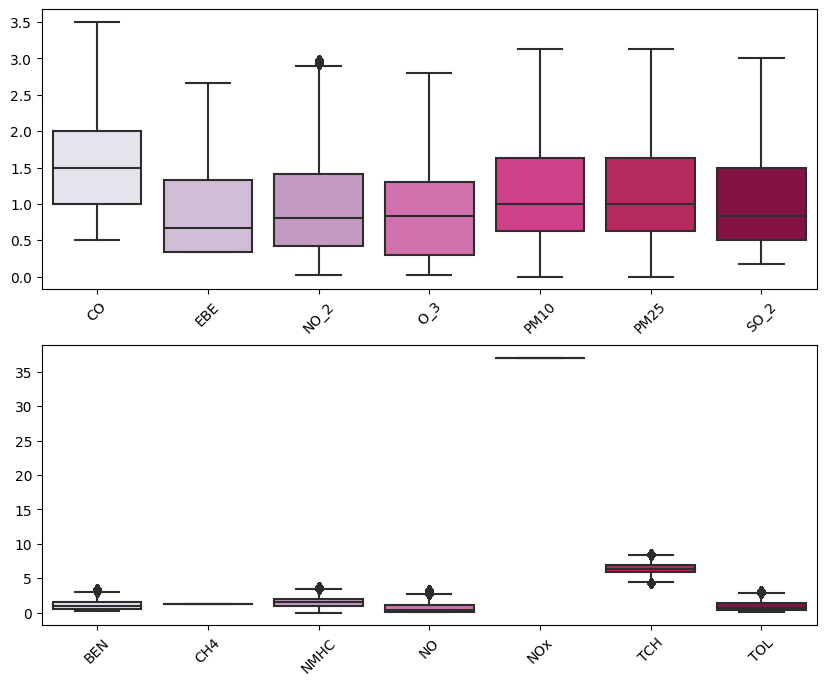

In [51]:
#STEP 3: DEAL WITH OUTLIERS/ NORMALIZE
df_top = df[['CO', 'EBE', 'NO_2', 'O_3', 'PM10', 'PM25','SO_2']]
df_bottom = df[['BEN', 'CH4', 'NMHC', 'NO', 'NOx', 'TCH', 'TOL']]

fig, axs = plt.subplots(2, figsize=(10, 8))

# First plot with first 7 rows
sns.boxplot(data=df_top, palette='PuRd', ax=axs[0])
axs[0].set_xticklabels(df_top.columns, rotation=45)

# Second plot with last 7 rows
sns.boxplot(data=df_bottom, palette='PuRd', ax=axs[1])
axs[1].set_xticklabels(df_bottom.columns, rotation=45)

plt.show()

In [44]:
#IQR OUTLIER REMOVAL AND NORMALIZATION

from sklearn.preprocessing import RobustScaler


# Get the columns to normalize
pollutants = df.columns[1:-1]

# Find outliers using the IQR method with k=1.5
Q1 = df[pollutants].quantile(0.25)
Q3 = df[pollutants].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#show number of outliers
outliers = (df[pollutants] < lower_bound) | (df[pollutants] > upper_bound)
print(outliers.sum())

#Remove outliers
df[pollutants] = df[pollutants].mask(outliers)

BEN     16966
CH4     51798
CO      13762
EBE     19953
NMHC     5935
NO      27420
NO_2     5160
NOx     52550
O_3       327
PM10     8603
PM25     8080
SO_2     5006
TCH     11358
TOL     17246
dtype: int64


In [47]:
# Fill NaN values using time-based interpolation
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.interpolate(method='time', limit_direction='both')
df = df.reset_index(drop=False)

In [ ]:
nan_counts = df.isnull().sum()
print(nan_counts)

In [50]:
# Normalize each column using the interquartile range (IQR) method
for pollutant in pollutants:
    col = df[pollutant]
    scaler = RobustScaler(with_centering=False, quantile_range=(25.0, 75.0), copy=True, with_scaling=True)
    df[pollutant] = scaler.fit_transform(col.values.reshape(-1,1))

In [ ]:
df.head(100)

In [36]:
#Z-SCORE Normalization

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index of the DataFrame
df = df.set_index('date')

from scipy.stats import zscore

# Get the columns to normalize
pollutants = df.columns[1:-1]

# Normalize each column using z-score with a threshold of ±2.5
for pollutant in pollutants:
    col = df[pollutant]
    zscore_col = zscore(col)
    mask = (zscore_col > -2.5) & (zscore_col < 2.5)
    df[pollutant] = np.where(mask, col, np.nan)
    df[pollutant] = df[pollutant].interpolate(method='time', limit_direction='both')


In [54]:

# Save the DataFrame to a CSV file in the current working directory
df.to_csv('C:\\Users\\eleni\\Documents\\Diplw\\Jupyter-Notebooks\\diplw\\clean_iqr.csv', index=False)